# Report for 2D Project Physical World and Digital World

Cohort: F04

Team No.: 10


# Introduction

Write your introduction here. Describe the problem you want to solve and a brief of your approach and summary of your result.

In this experiment, we were tasked to use machine learning and prediction to accurately determine the temperature of a water bath using a thermal sensor. The thermal sensor used is connected to a Raspberry Pi and usually takes approximately 2 minutes to reach thermal equilibrium with the water bath to accurately read the temperature of the water bath. For our approache, we are using linear regression model obtained from carrying out experiment of measuring different water bath temperature using our thermal sensor in oreder to predict the temperature with an accuracy of 1.5 degrees Celsius within 10 seconds of the unknown temperature water bath. 

We then have to use Kivy to create a Graphical User Interface (GUI) to show the current temperature reading, elapsed timing, predicted temperature and time taken to predict the temperature. 

We managed to collect temperature against time data at 20 different water temperatures, and build a linear regression model.


# Description of Data from Experiment

## Data Collection

A 1-litre water bath, measured at Tw = 60°C using a thermometer, was first prepared in a styrofoam box, which greatly reduces heat exchange between the water bath and the surroundings. The Raspberry Pi temperature sensor was then placed in the water bath, which measures the temperature of the sensor Ts(t), from t = 0s until t = 70s (when the final temperature was shown to plateau), at intervals of 2s. The readings were displayed on the terminal, and then saved in an excel file.
During data collection, we closed the lid of the box to prevent heat exchange, especially convection, with the surroundings. As expected, Tw stayed constant throughout the experiment.
Another 20 sets of data were collected by reducing Tw between 60°C to 26°C. With more data points, we can plot more ln graphs against t to determine whether 𝜏 is a function of temperature or a constant which is independent of time. Additionally, the predictive model will be trained using more data sets for a more accurate prediction on the test day.
In order to measure if there is any systematic offset, which is given by +Terror = Ts(t = ∞) - Tw, we took the average of various Terror for different Tw. With the calculated systemic offset, we corrected our Ts(t) values during data preparation.


## Data Preparation

Describe how you prepare your data. Include any codes you have here.

For data preparation, we used excel to for data calculation and Python for data extraction.
For each data set of Temperature T(s) against time we obtained, we calculated 4 more set of features including **ln[(Ts(t) - Tw)/(Tamb - Tw)]**, **Ts,corrected(t)**, **ln[(Ts,corrected(t) - Tw)/(Tamb - Tw)]** and **dTs/dt**.

**Ts,corrected(t)** is calculated by adding Ts(t) to the systematic error of the sensor instruments. This allow us to get a more prominent linear graph of ln[(Ts,corrected(t) - Tw)/(Tamb - Tw)] against time for more accurate visualisation of Tau.

**dTs/dt** is calculated using :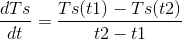
where t1 and t2 are any adjacent data point.

We then extract 3 features: **Ts(t)**, **dTs/dt**, **Tw** from all 20 data sets into x_data and y_data. This will be used for linear regression model prediction.


In [1]:
#Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
#Code to read an excel file
#We only have one excel file already consisting of all the data we need

# We recorded our data in multiple sheets in one excel file
sheetkeys = [59,56.5,55,52.6,49.3,48.5,46.3,44,42.5,40.7,38.9,36.6,34.9,32.3,30.1,28.6,26.5,17.1,15.1,12.9]
filename = "temp_data_final.xlsx"
dataframe = {}

for i in sheetkeys:
    dataframe[i] = pd.read_excel(filename, sheet_name = str(i))

## Data Format

Describe your data and its features. Include any codes or visualization of data.

**Experimental data:**
This is the data collected for 20 different water bath temperature

<img src="https://i.ibb.co/F0SZNMy/image.png" alt="Drawing" style="width: 600px;"/>

T_amb, temperature ambient is set to be constant at 25°C

T_w , temperature of water bath measured at the beggining

T_err, sensors systemetic error

T_max, maximum temperature reading from the sensors

Gradient, is the gradient of the ln(T(corrected)) against time

Tau is calculated using -1/Gradient

Time, T(s), ln(t(s)), T(corrected), ln(T(corrected)), dTs/dt are the features of the data.

**Feature extracted data:**
This is the data where we extracted Ts(t), dTs/dt, Tw for all 20 data set we collected

Example of x_data (pandas dataframe)
<img src="https://i.ibb.co/JQXc4RX/image.png" alt="Drawing" style="width: 150px;"/>

Example of y_data (pandas dataframe)
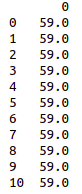




In [3]:
#Code to prepare the data for predicting
#We prepare the data by extracting the dTs/dt and Ts(t) and T_w out of the dataframe

def preprocess(df):
    # use this function to extract the features from the data frame
    x = df[["T(s)","dT/dt(s)"]] #extract T(s) and dTs/dt
    x_add = x.drop(x.index[0:2]) #drop the first 2 row since they are invalid for the model
    y_add = [df.iat[0,1]]*(len(x)-2) #extract the respective Tw the data points
    #return the x and y data to be append into the x_data and y_data
    return (x_add, y_add)

x_data = pd.DataFrame() #create empty dataframe for x data and y data for model training
y_data = pd.DataFrame()

for i in dataframe:  #append all the features of the 20 data sets into x_data and y_data to prepare for model
    x_data = x_data.append(preprocess(dataframe[i])[0])
    y_data = y_data.append(preprocess(dataframe[i])[1])
    

In [4]:
# Code to split the data to train and test

def prepare_train_test(x_data,y_data):
    x_data = x_data.values #converting dataframe into numpy array
    y_data = y_data.values
    #We split 80% to train and 20% to test
    x_train, x_test, y_train, y_test = train_test_split( x_data , y_data , test_size = 0.2, random_state = 913313)
    #Return 2 tuples of train and test data
    return (x_train,y_train) , (x_test,y_test)

data_train, data_test = prepare_train_test(x_data,y_data)

# Training Model

Describe how you train your model. Include any code and output

We will build our linear regression model based on the assumption that there is no work done on or by sensor: 
            <img src="https://i.ibb.co/GM0dM66/image.png" alt="Drawing" style="width: 200px;"/>
                                
Thus, we our independent variables are Ts(t) and dTs/dt while our dependent variable is Tw. As a result we use multiple linear regression to model this relationship.<img src="https://i.ibb.co/nfHxg5n/image.png" alt="Drawing" style="width: 200px;"/>

Using 80% of our data set to train, we came up with the model as follow:

Tw = 4.51129064 * dTs/dt + 1.02516988 * T(s) + 0.02595904

Hence our coefficient C1 = 4.51129064, C2 = 1.02516988, y-intercept C3 = 0.02595904



In [5]:
# write a code to train the model
# the function should return the trained model
from sklearn.linear_model import LinearRegression

def train_model(data):
    reg = LinearRegression() #creating a regression model
    reg.fit(data[0], data[1])
    return reg

model = train_model(data_train)
results = {'coefficients': model.coef_ , 'intercept' : model.intercept_ }
print(results)

{'coefficients': array([[1.02516988, 4.51129064]]), 'intercept': array([0.02595904])}


# Verification and Accuracy

Describe how you check the accuracy of your model and its result. State any analysis you have and the steps you have taken to improve its accuracy.

To verify our model we use cross validation method as we have already split the data into training set and testing set, we will use the model to predict y data from the x data of test set and compare it y test and calculate mean square error and R2 score to determine the accuracy of our model

Since our R2 score is 0.9956653341513484 and mean squared error is 0.7282246341822299 we conclude that the accuracy of our model is high.

Furthermore, we observe the our model is very similar to the model:
            <img src="https://i.ibb.co/GM0dM66/image.png" alt="Drawing" style="width: 200px;"/>
in a way that the coefficient for Ts(t) is very close to 1 and the y-intercept is also close to 0.Thus, this helps us to further justify the validity of our model.


In [6]:
# Code to predict the final temperature of the data_test set
y_pred = model.predict(data_test[0])

In [7]:
# write a code to check your accuracy

output = {'mean squared error': mean_squared_error(data_test[1], y_pred), 'r2 score': r2_score(data_test[1], y_pred)}
print(output)


{'mean squared error': 0.7282246341822309, 'r2 score': 0.9956653341513484}
